In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.dataset_custom import *
from models.lstm_vae import *
from models.lstm_vae_vanilla import *
import torch
import random
from config import *

import numpy as np

In [2]:
types = ['lstm_vae', 'lstm_vae_vanilla']
vae_type = types[1]

In [3]:
model_list = os.listdir(model_results+ vae_type)
os.listdir(model_results+ vae_type)

['lstm_vae_vanilla_16_ft_4s_sc.pth', 'lstm_vae_vanilla_4_ft_4s_sc.pth']

columns
# 
tempetarue
voltage

logico per ogni routa (segno corrente)

singola routa:
    motocurrent
    speed 
    voltage
    temperature
    
quattro route:
    motocurrent
    speed 
    voltage
    temperature

In [4]:
model_num = 1

print(model_list[model_num])

lstm_vae_vanilla_4_ft_4s_sc.pth


In [5]:
checkpoint  = torch.load(model_results + vae_type + '/' + model_list[model_num])
params_conf = checkpoint['param_conf']

In [6]:
cols = params_conf['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

In [7]:
target = None

if target != None:
    no_features = len(cols) - len(target)
else:
    no_features = len(cols)
    target = cols

if scaled:
    train_iter = torch.load('../dataloader/train_dataloader_{}_ft_{}_{}.pth'.\
                            format(n_features, sampling_rate, sequence_length))
    test_iter = torch.load('../dataloader/test_dataloader_{}_ft_{}_{}.pth'.\
                            format(n_features, sampling_rate, sequence_length))
else:
    train_iter = torch.load('../dataloader/train_dataloader_not_scaled_{}_ft_{}_{}.pth'.\
                            format(n_features, sampling_rate, sequence_length))
    test_iter = torch.load('../dataloader/test_dataloader_not_scaled_{}_ft_{}_{}.pth'.\
                            format(n_features, sampling_rate, sequence_length))

In [8]:
if vae_type == 'lstm_vae':
    model = LSTM_VAE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
            no_features=params_conf['n_features'], output_size=params_conf['output_size'],
            embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
            Nf_lognorm=params_conf['n_features'], Nf_binomial=0,
                    n_layers=params_conf['n_layers'])
elif vae_type == 'lstm_vae_vanilla':
    
    model = LSTM_VAEV(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        no_features=params_conf['n_features'], output_size=params_conf['output_size'],
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                n_layers=params_conf['n_layers'])
    
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

LSTM_VAEV(
  (encoder): Encoder_vaev(
    (LSTMenc): LSTM(4, 128, num_layers=4, batch_first=True)
    (LSTM1): LSTM(128, 64, num_layers=4, batch_first=True)
    (mu): LinConstr()
    (log_var): LinConstr()
    (act2): InverseSquareRootLinearUnit()
  )
  (decoder): Decoder_vae(
    (act2): InverseSquareRootLinearUnit()
    (act3): ClippedTanh()
    (LSTMdec): LSTM(40, 64, num_layers=4, batch_first=True)
    (LSTM1): LSTM(64, 128, num_layers=4, batch_first=True)
    (par1): Linear(in_features=128, out_features=4, bias=True)
    (par2): Linear(in_features=128, out_features=4, bias=True)
    (par3): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [9]:
# These are the real time series
# These are the real time series
# These are the real time series
#for i in range(len(columns)):
#    fig = plt.figure(figsize=(12,4))
#    plt.plot(test_iter.dataset.df_data.iloc[0:100,i])
#######################################################
#####################################################
#######################################################
#####################################################

#list(test_iter._index_sampler.sampler.__iter__())

#x, y, idx= next(iter(test_iter))

#idxs = list(range(idx[0], idx[0] + sequence_length))

#test_iter.dataset.df_data.iloc[idxs,0]

 #i=0
#x.flatten(0,1)[:14,i]

#fig = plt.figure(figsize=(12,4))
#plt.plot(x[0][:,0])
#plt.plot(x[1][:,0])

#[batch][time,feat]
#x[0][:,0]

#x[1][:,0]

In [10]:
num_batch = 10
shift = np.random.randint(len(test_iter.dataset.df_data)-1000)
x = np.zeros((num_batch, sequence_length, len(cols)))
for i in range(num_batch):
    
    x[i,:,:] = test_iter.dataset.df_data.iloc[shift + i*sequence_length:shift + (i+1)*sequence_length,:]\
    .values
x = torch.from_numpy(x).float()

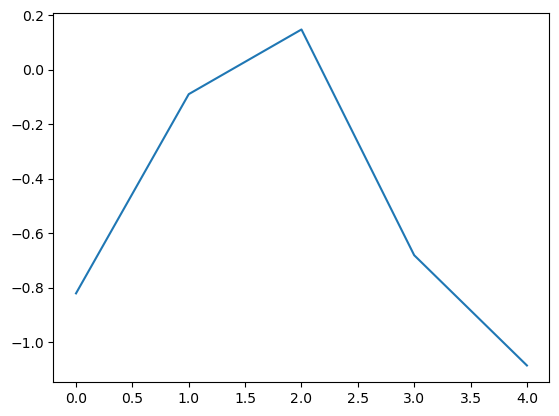

In [11]:
#x, y, idx = next(iter(test_iter))
if vae_type == 'lstm_vae':
    x, mu, sigma, mu, sigma, yo = model(x.to('cuda'))
    yo = yo[0]
elif vae_type == 'lstm_vae_vanilla':
    x, mu, sigma, yo = model(x.to('cuda'))
    yo = yo[0]

feat = 0

if predict:
    plt.plot(y[0,:,feat].to("cpu").detach().numpy())
else:
    plt.plot(x[0,:,feat].to("cpu").detach().numpy())

In [12]:
#sequence_length=50
#out_window=10

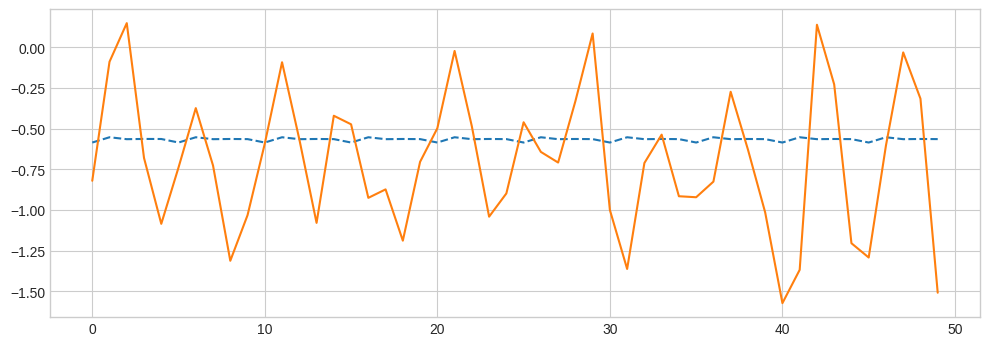

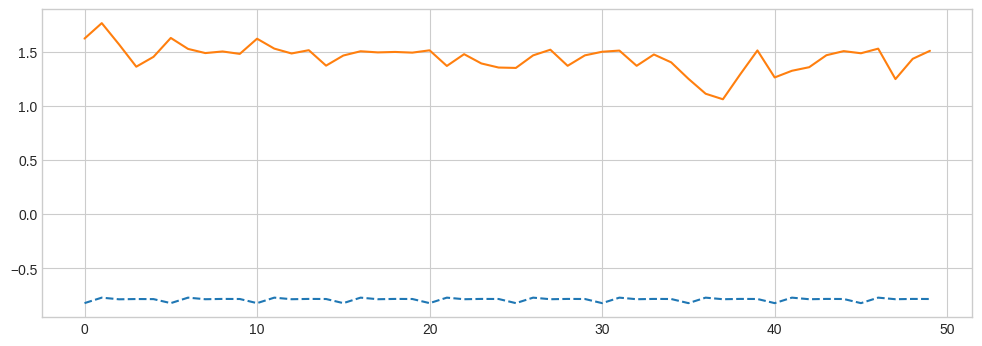

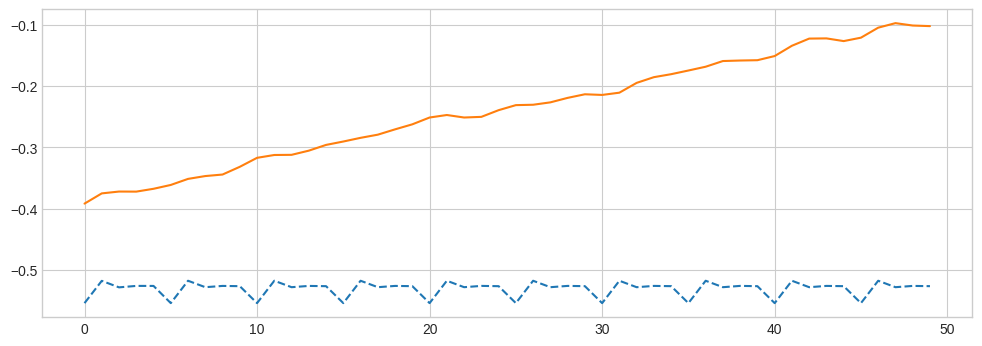

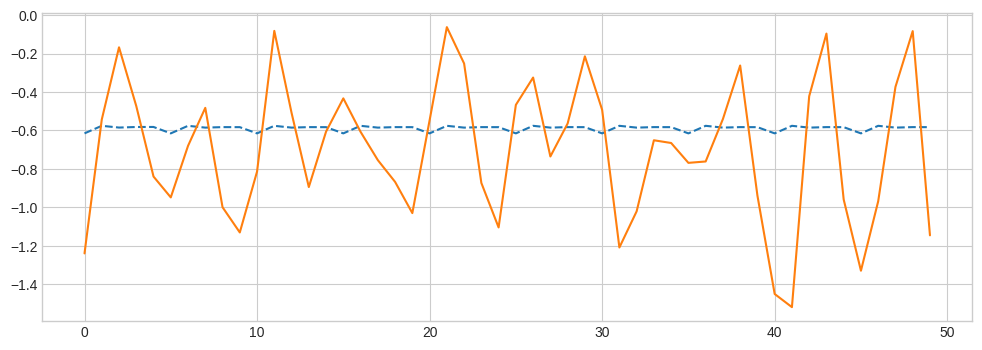

In [13]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), linestyle='--')

    plt.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy())

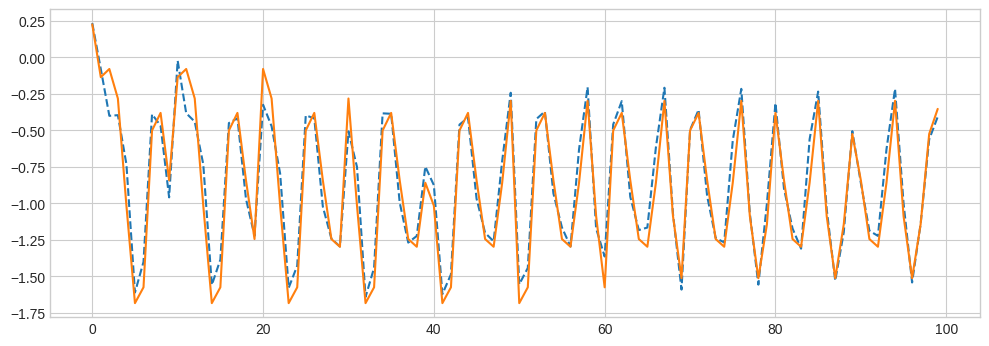

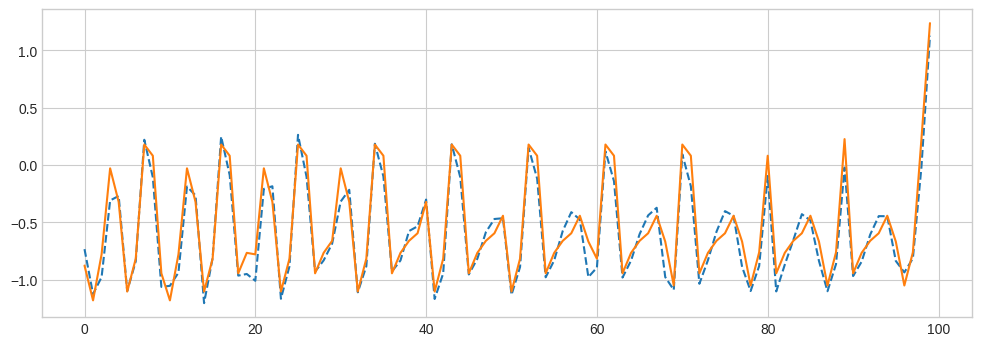

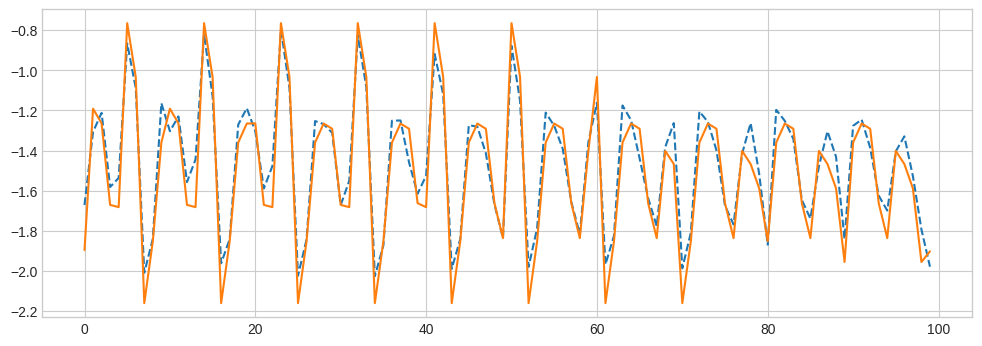

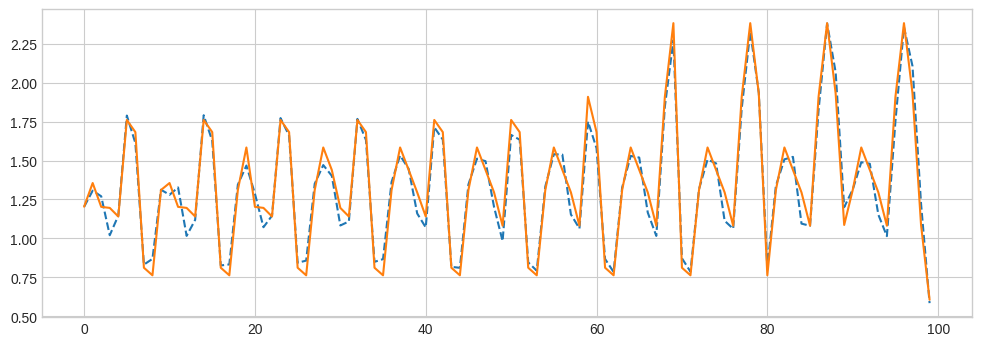

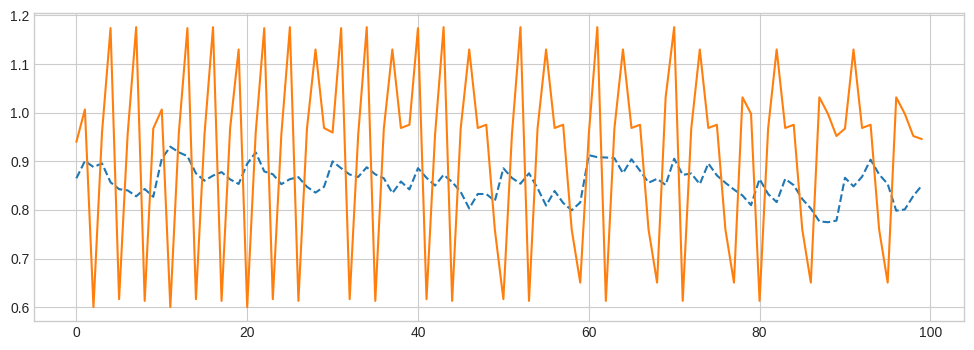

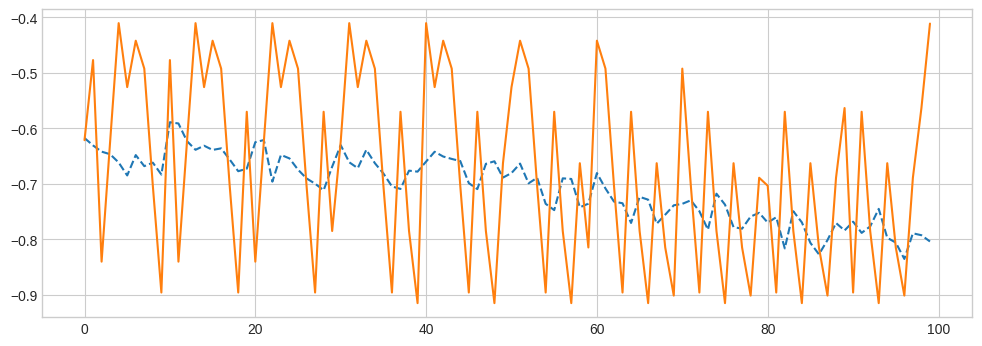

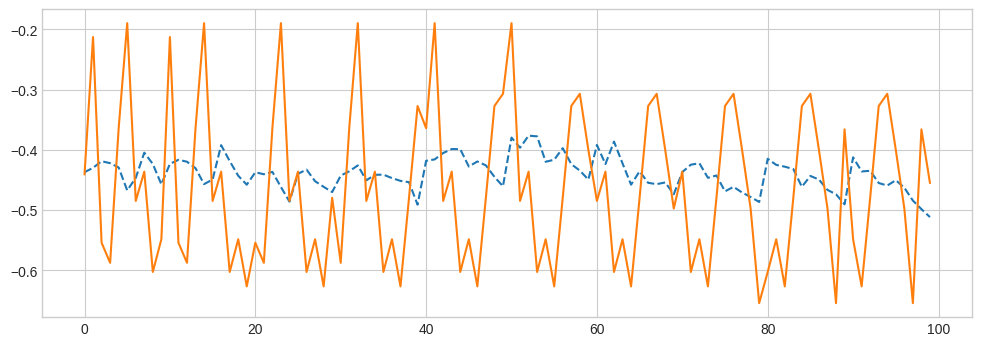

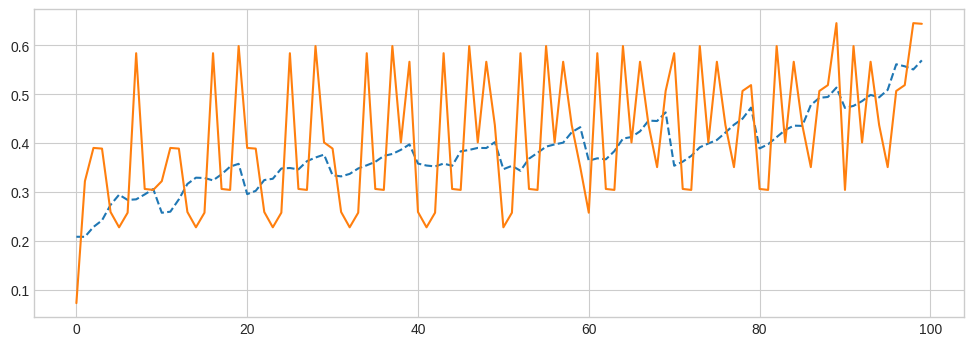

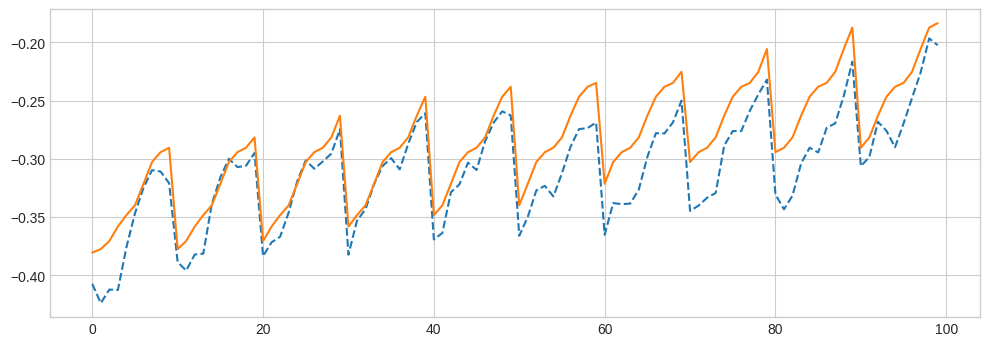

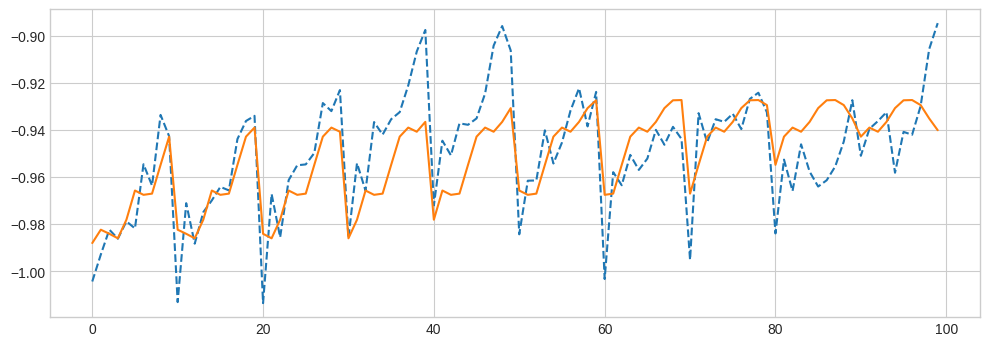

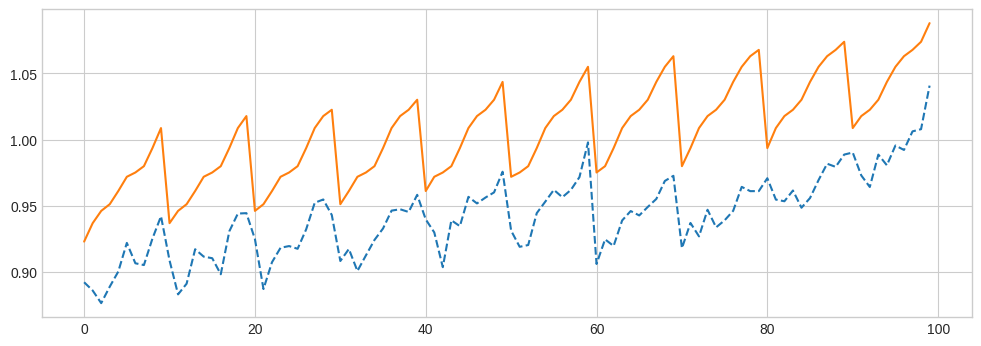

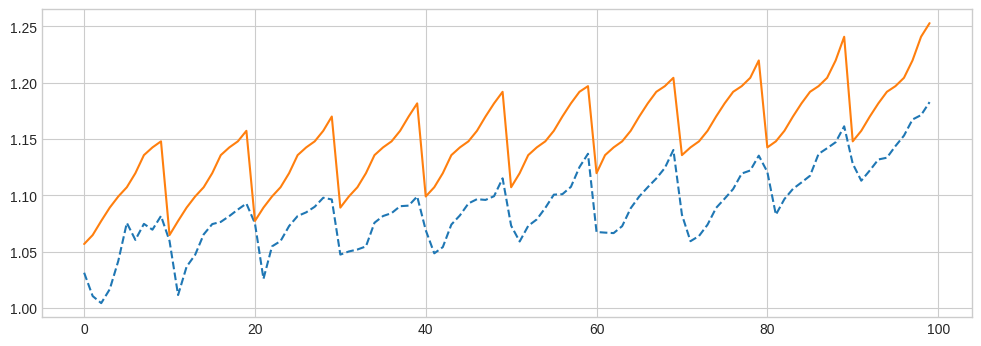

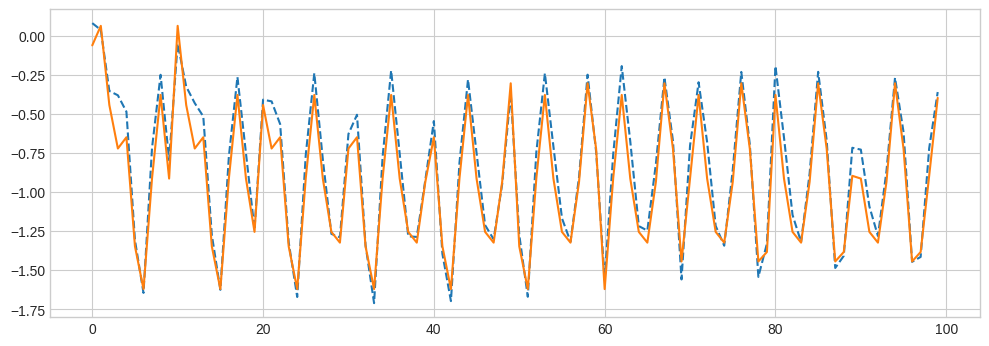

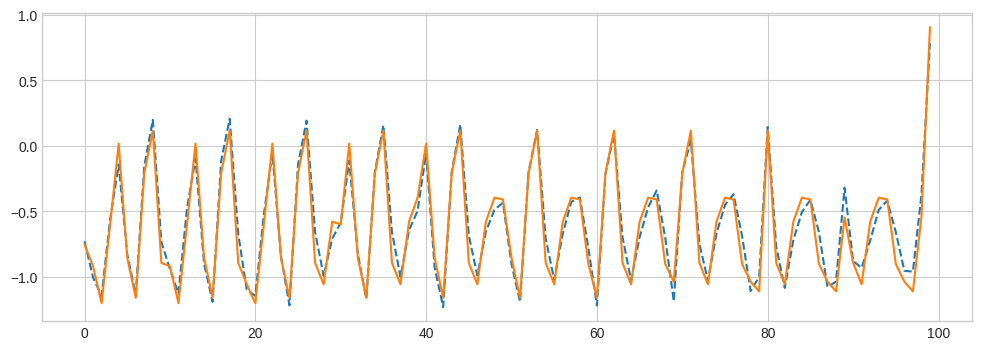

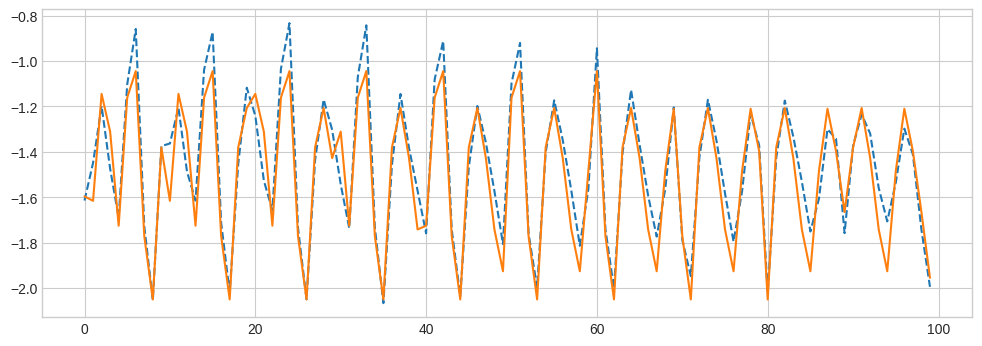

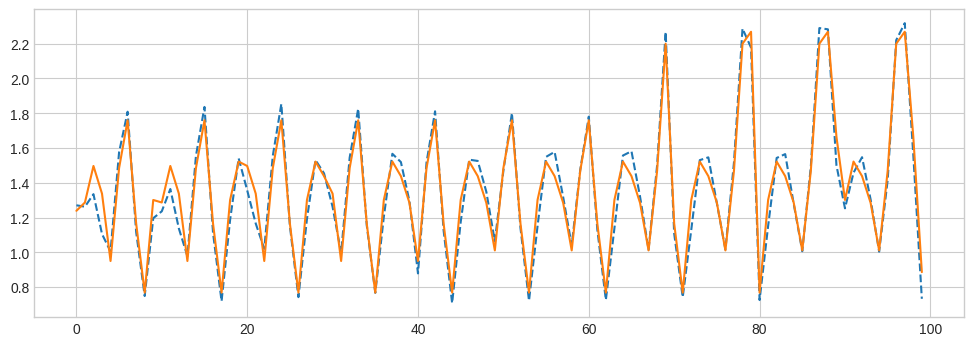

In [23]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), linestyle='--')

    plt.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy())

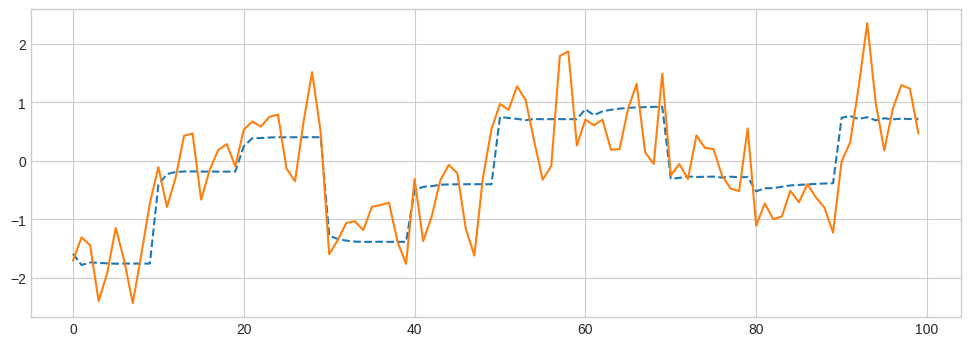

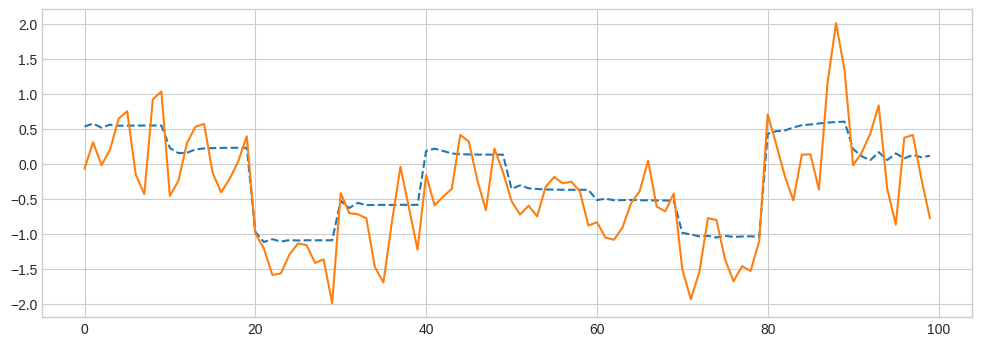

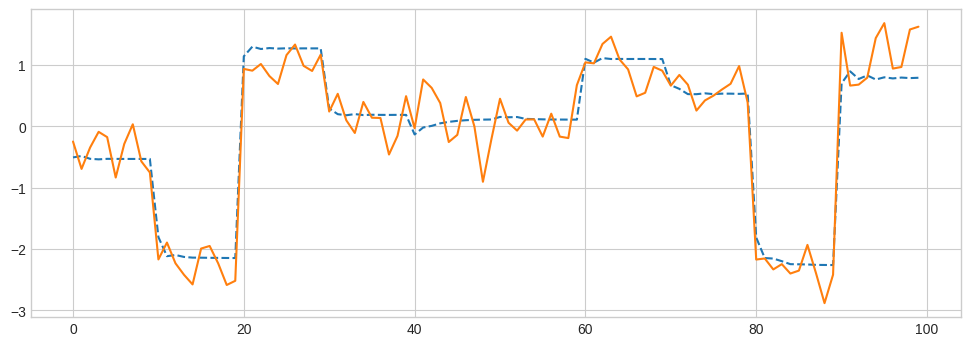

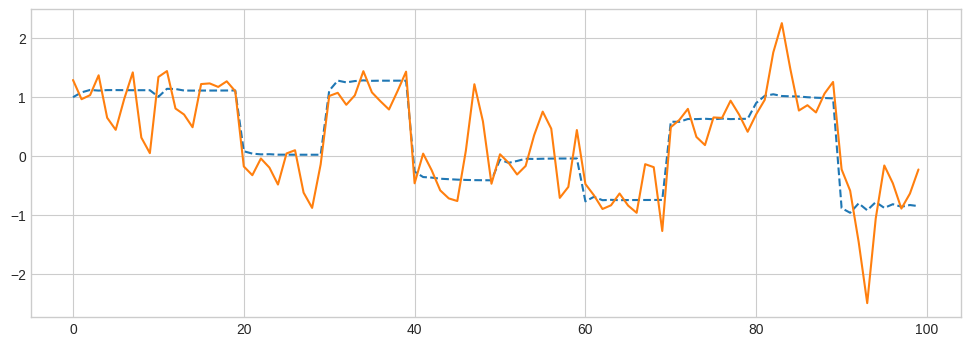

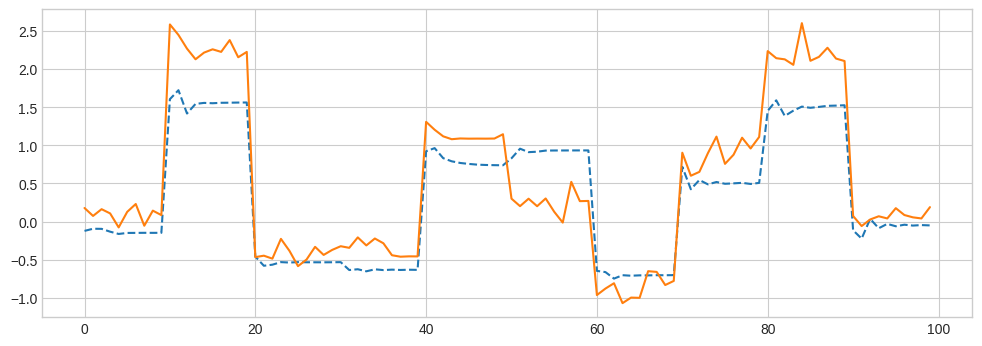

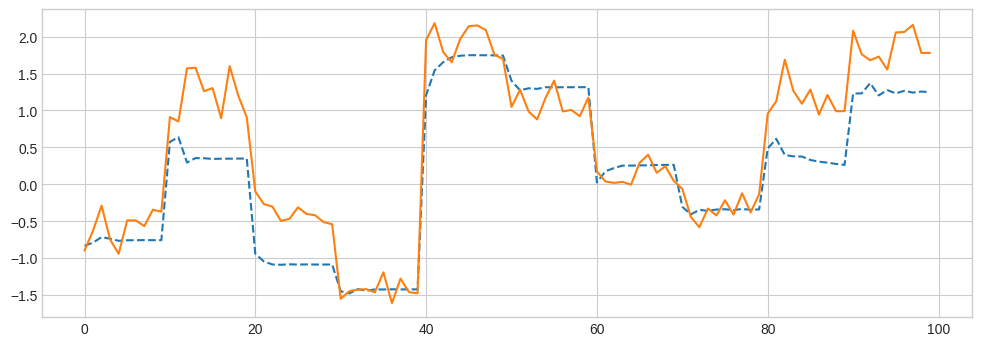

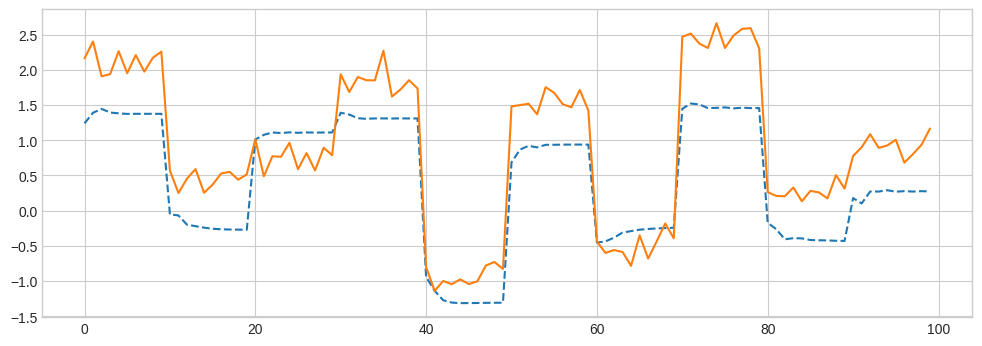

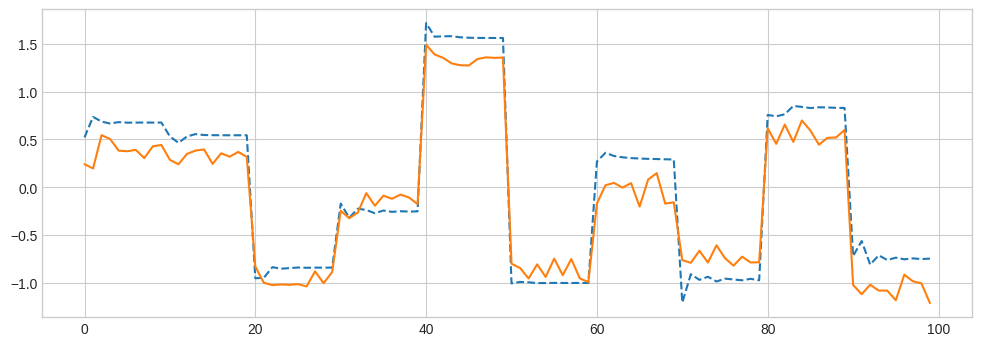

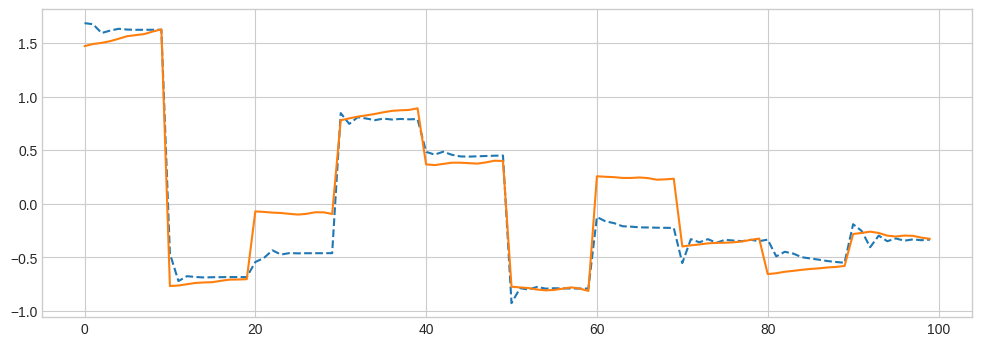

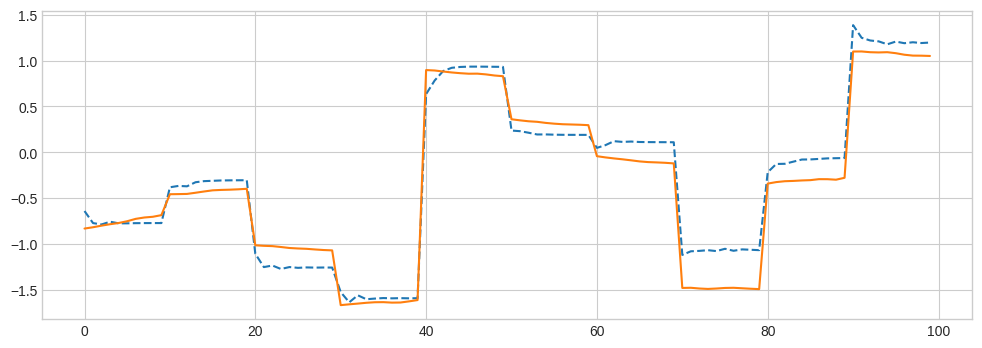

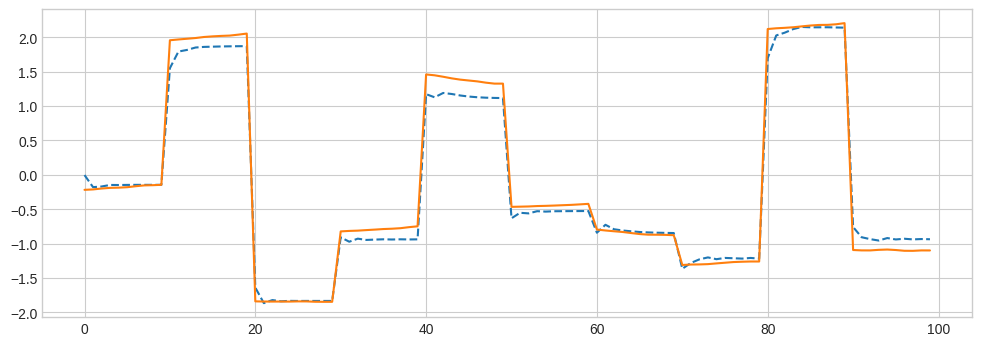

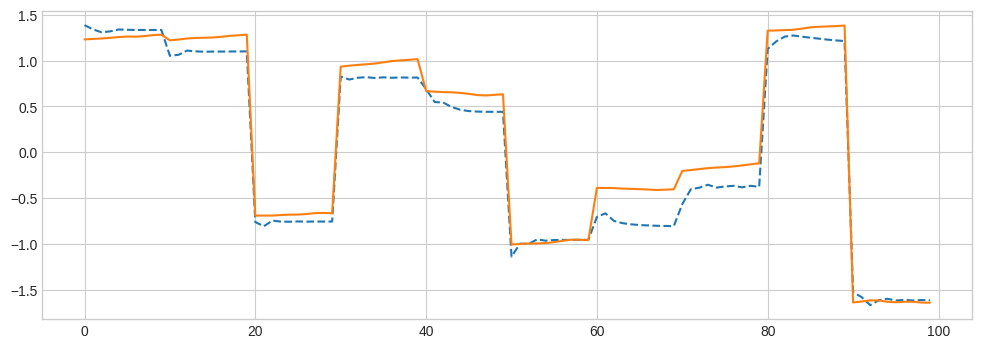

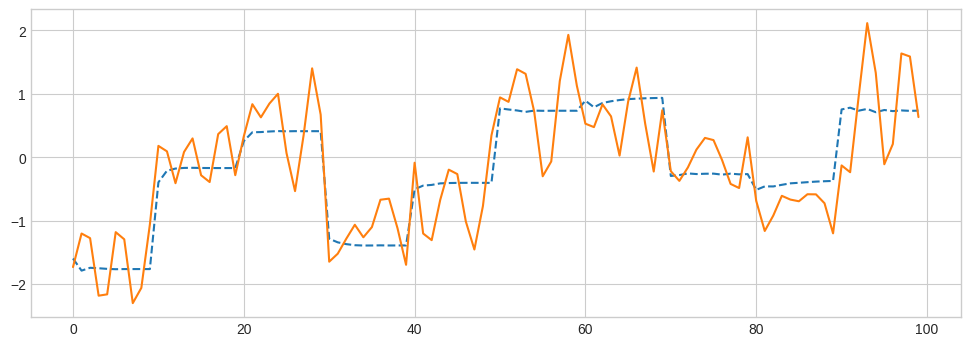

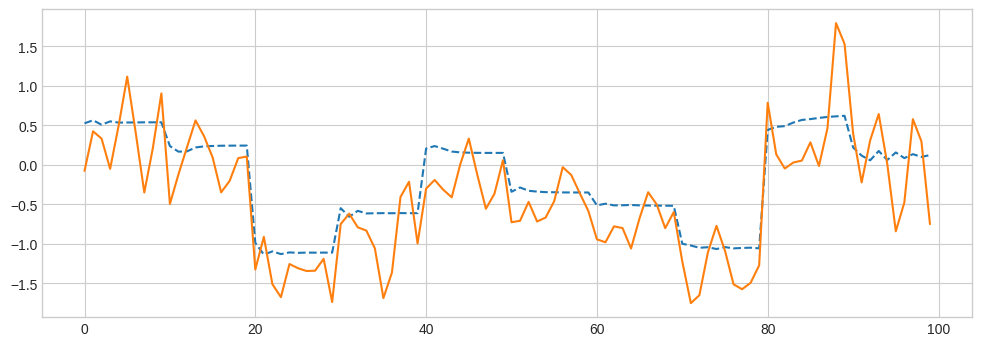

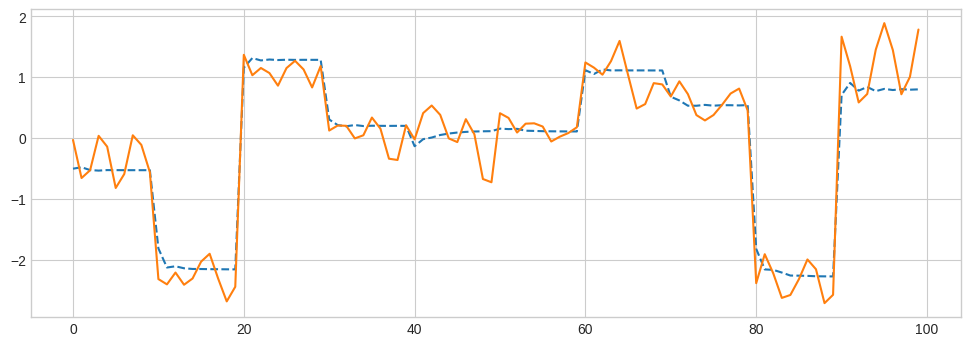

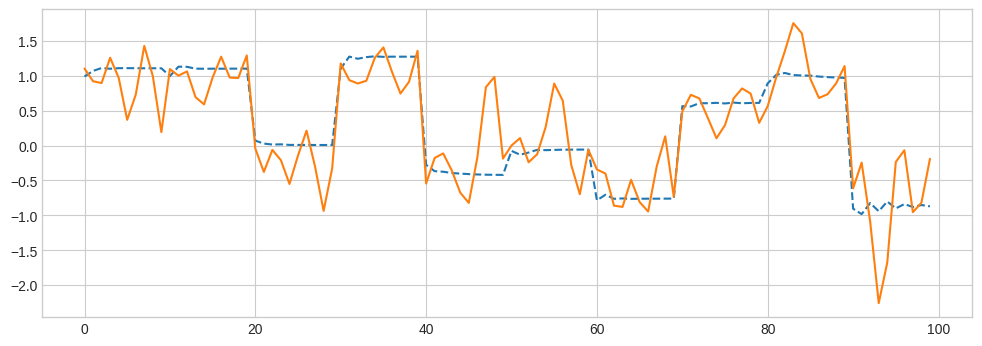

In [44]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), linestyle='--')

    plt.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy())

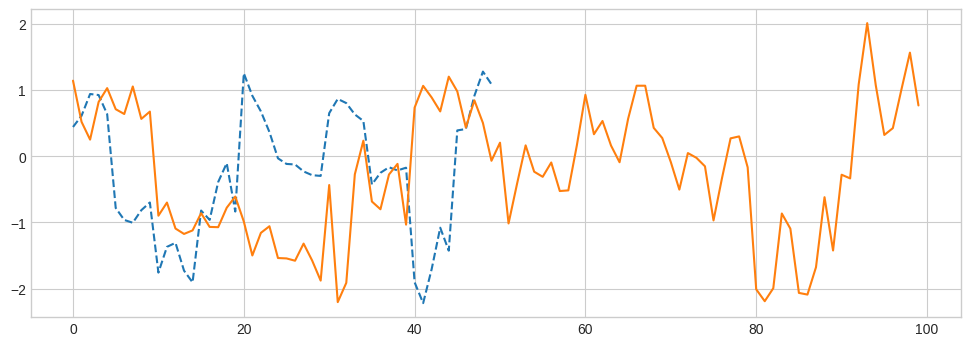

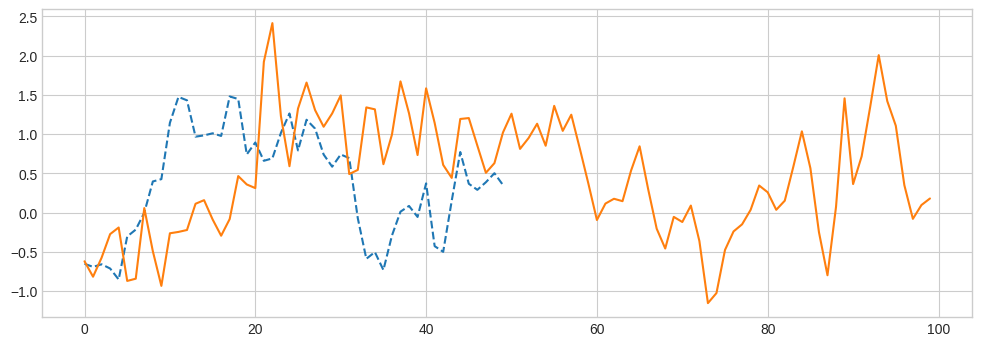

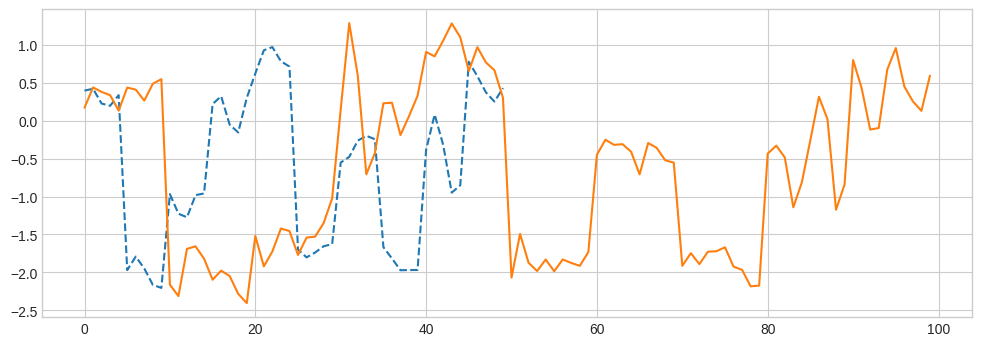

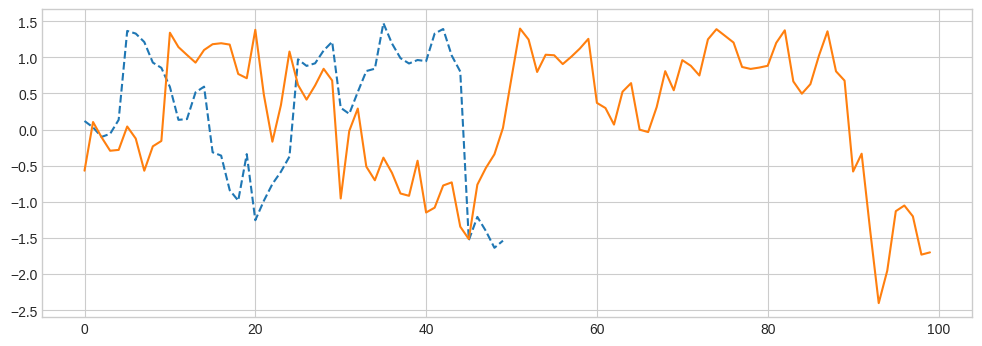

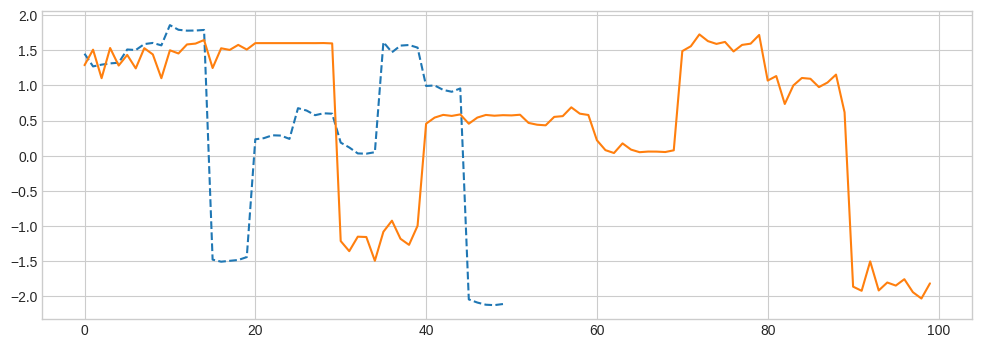

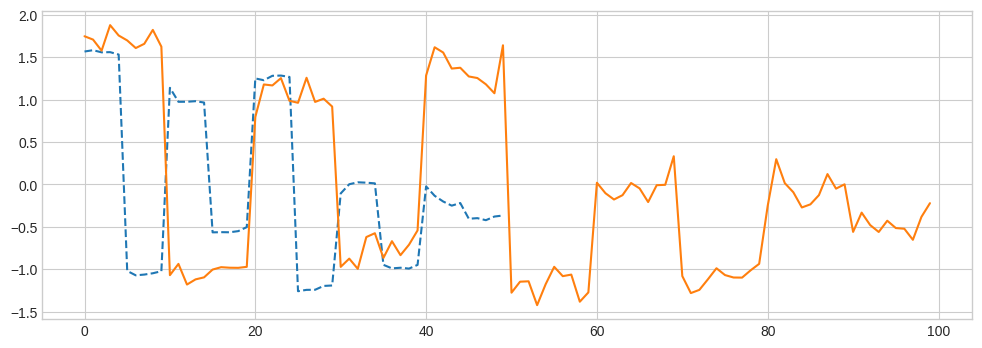

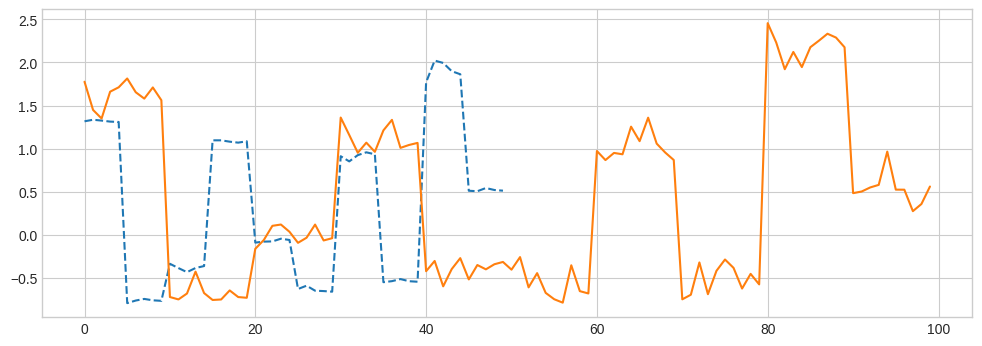

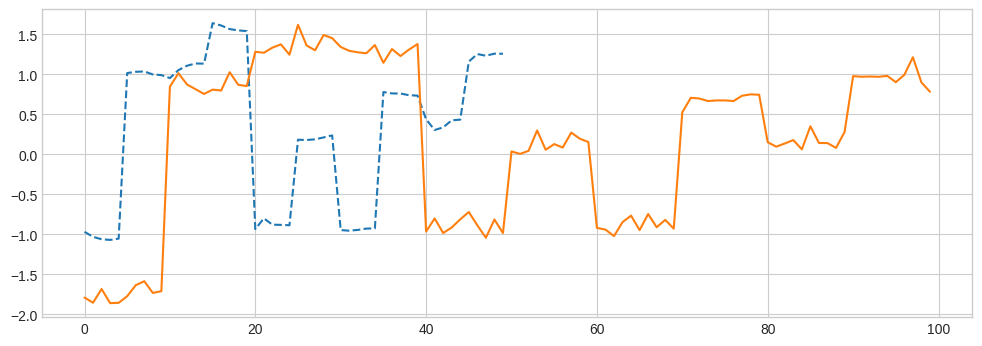

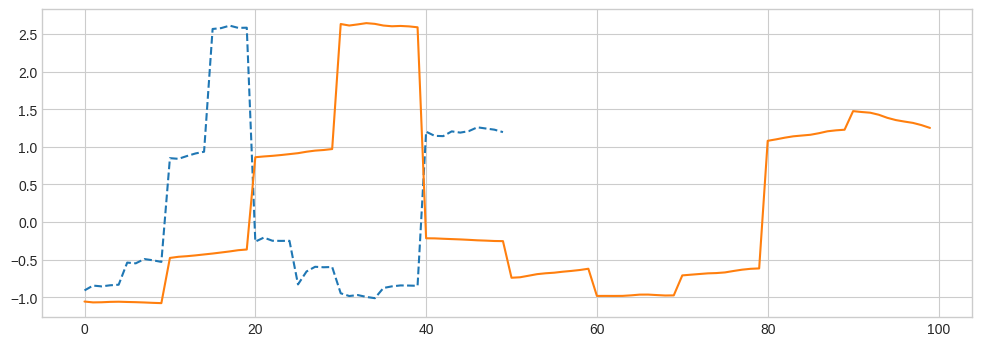

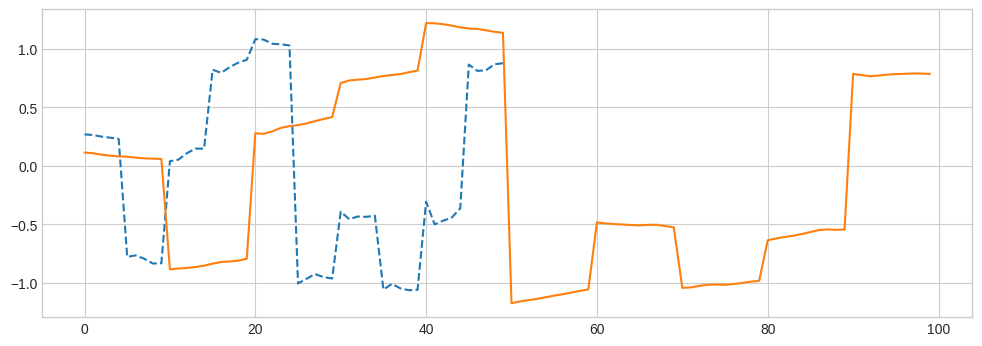

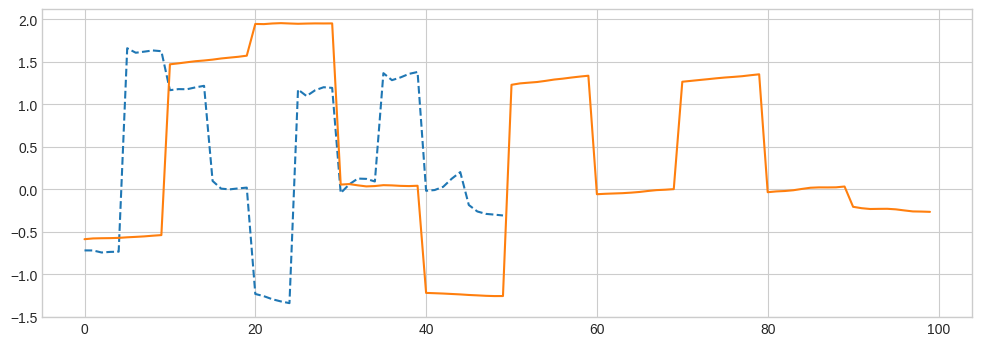

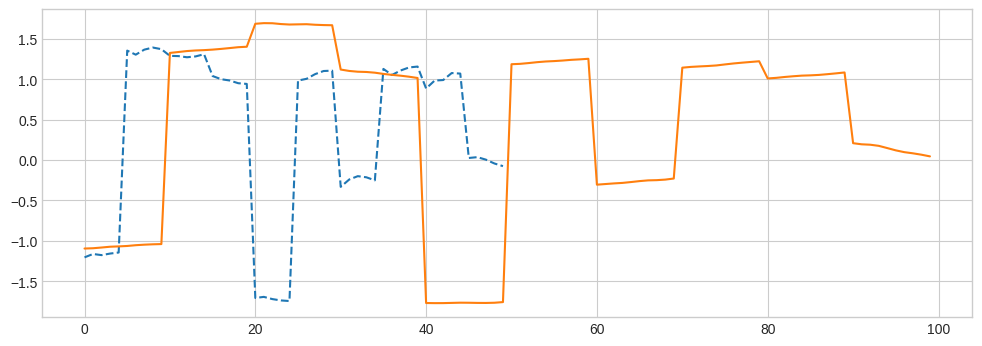

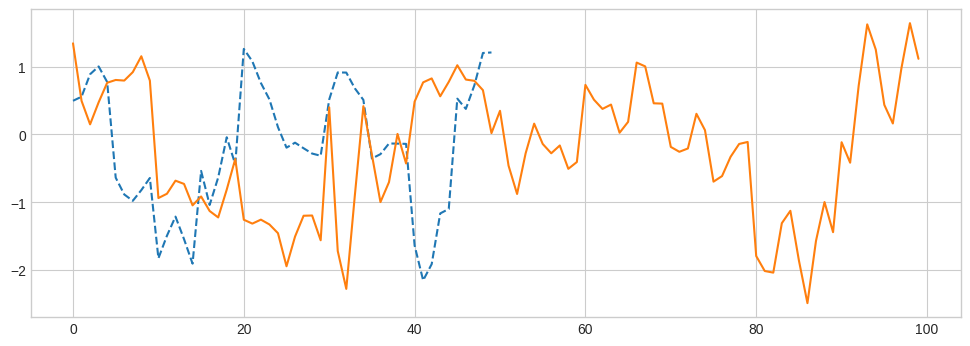

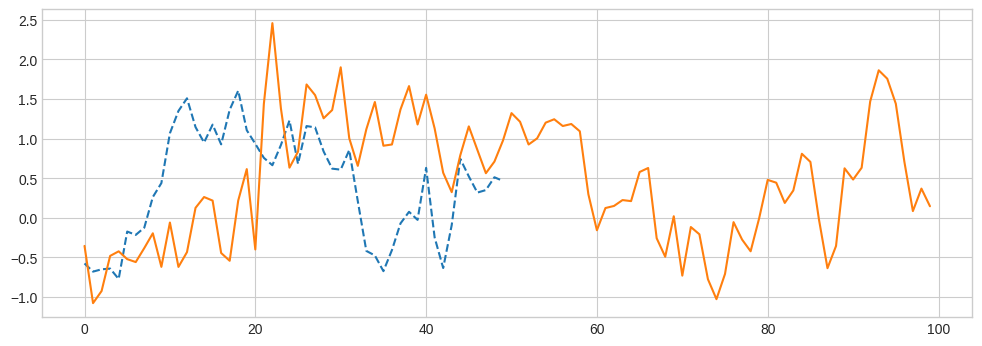

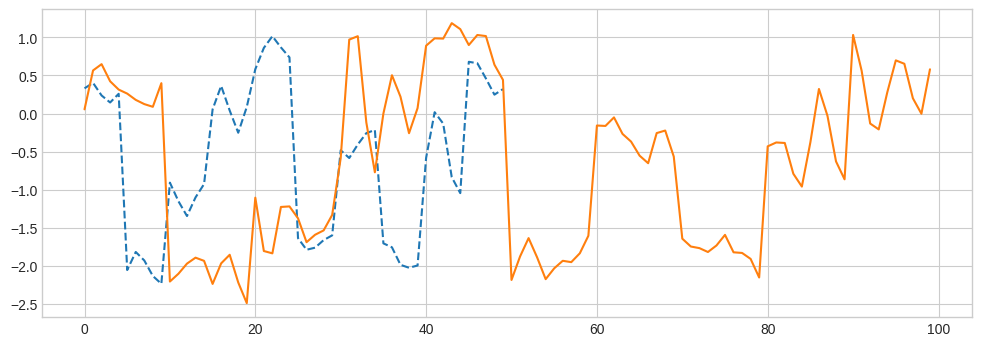

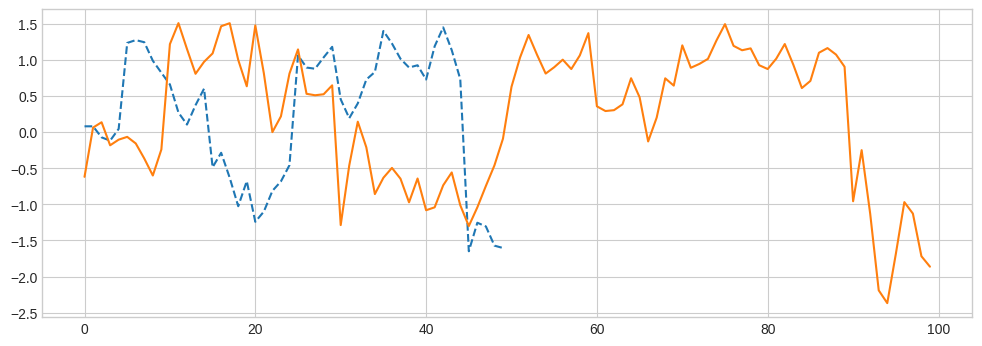

In [15]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), linestyle='--')

    plt.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy())

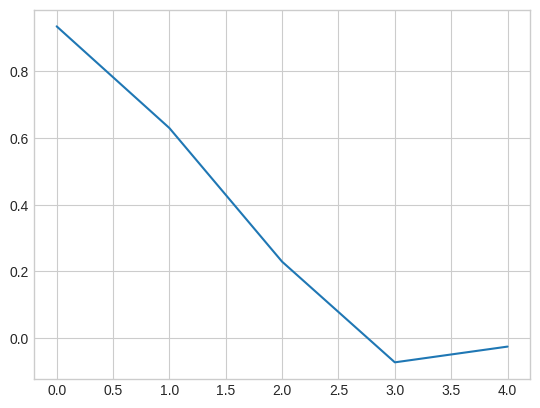

In [18]:
x, y = next(iter(test_iter))
x, enc, yo = model(x.to('cuda'))
feat = 0

if predict:
    plt.plot(y[0,:,feat].to("cpu").detach().numpy())
else:
    plt.plot(x[0,:,feat].to("cpu").detach().numpy())

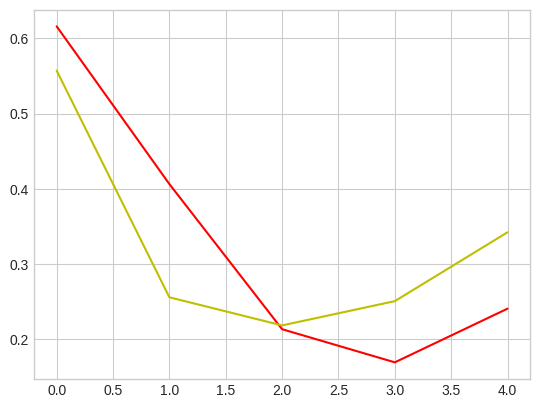

In [19]:
plt.plot(yo[1,:,feat].to("cpu").detach().numpy(), 'r')
plt.plot(y[1,:,feat].to("cpu").detach().numpy(), 'y')

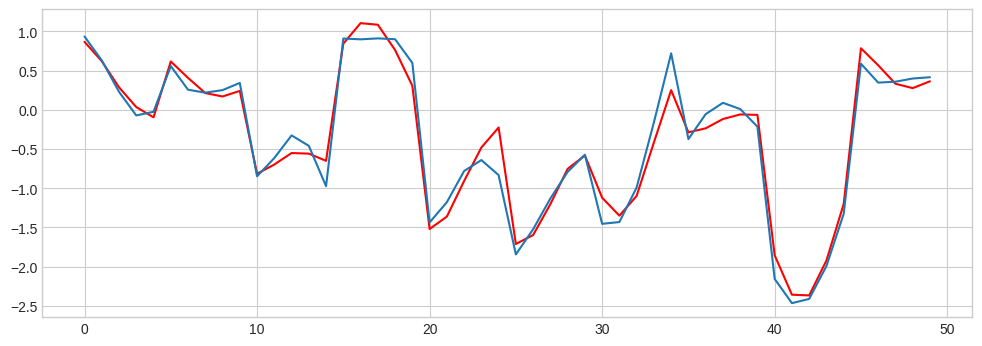

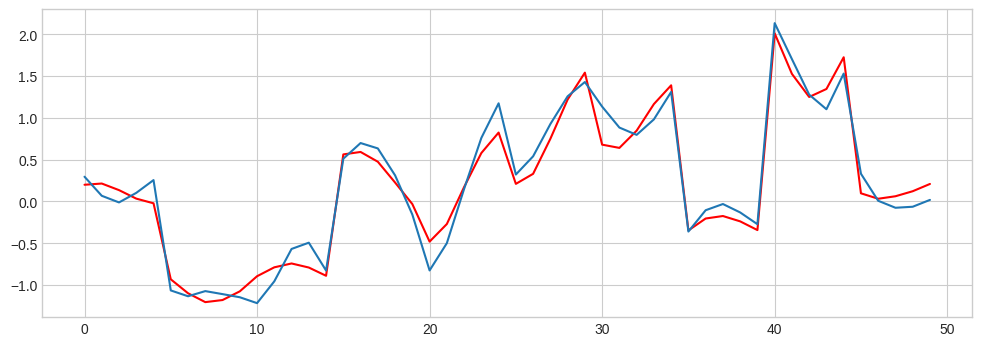

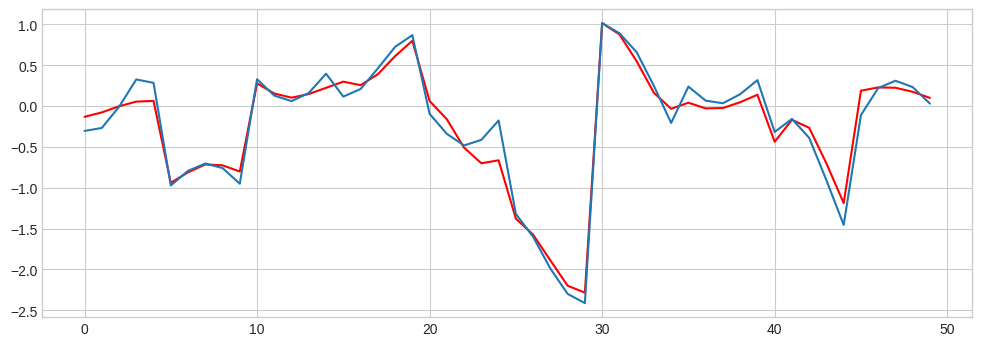

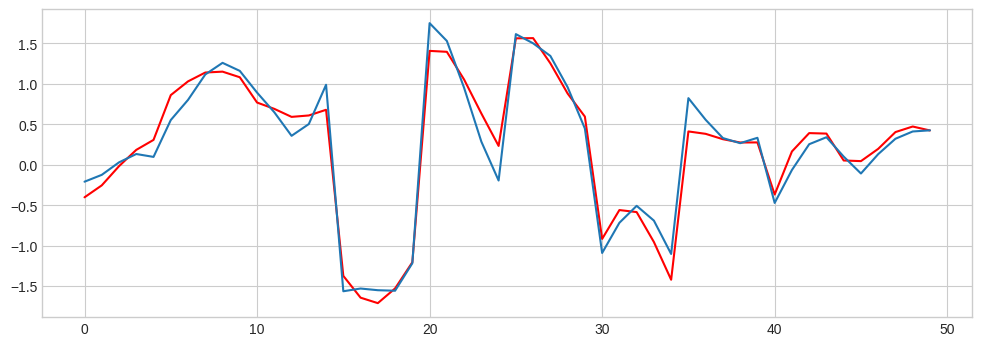

In [20]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:100,i].to("cpu").detach().numpy(), 'r')
    plt.plot(x.flatten(0,1)[:100,i].to("cpu").detach().numpy())

#Inject anomaly

In [21]:
x, y = next(iter(test_iter))

In [25]:
n_std = 5

In [26]:
batch = 5
x_a = x.clone()
change_value = [0, 1,2]
injected = []
for i in range(x.shape[2]):
    print(i)
    if i in change_value:
        print('changing')
        inject = list(x_a[batch ,:, i].cpu().numpy())
        inject_anomaly = [t + n_std*np.std(inject)*random.uniform(0.8,1) for t in inject]
        #x_a[batch,:, i] =  torch.Tensor(fake)
        x_a[batch,:, i] = torch.Tensor(inject_anomaly)
        
        injected.append(i)
    
    if all(x_a[batch,:,i]==x[batch,:,i]):
        print('original tensor and anomalous are the same on features',i)

0
changing
1
changing
2
changing
3
original tensor and anomalous are the same on features 3


In [27]:
idx = batch*sequence_length
x_a, enc, yo_a = model(x_a.to('cuda'))
x, enc, yo = model(x.to('cuda'))
len(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())

40

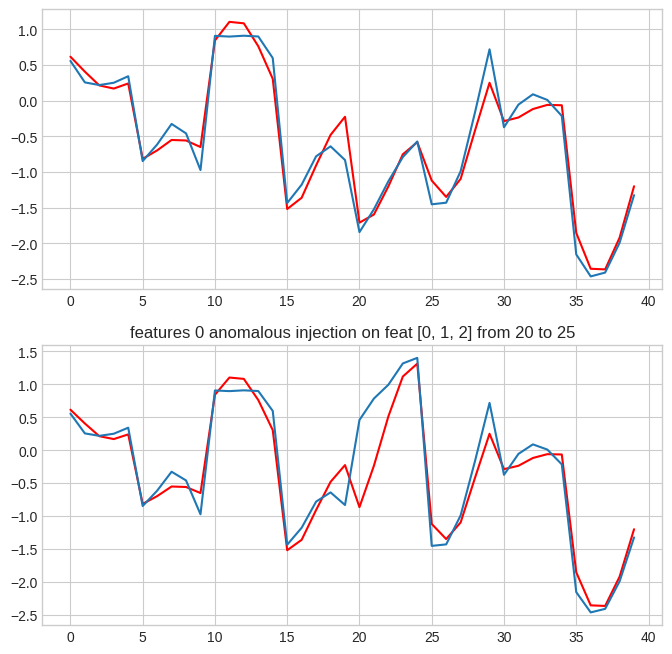

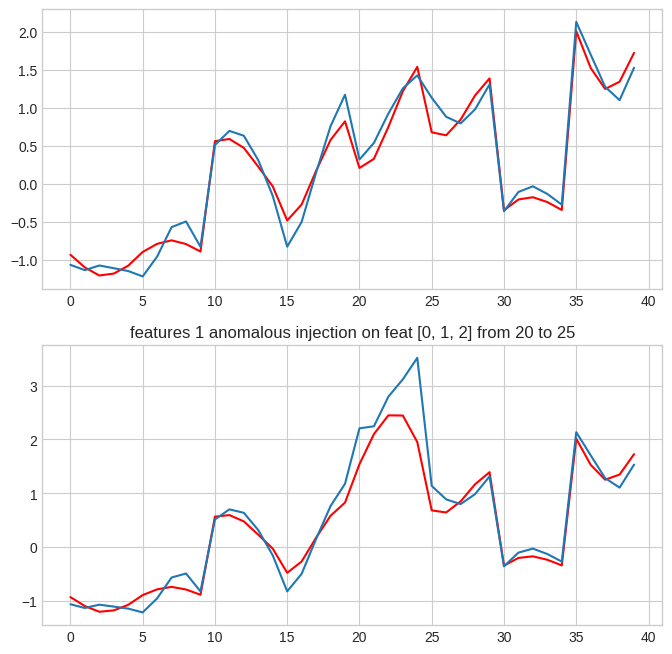

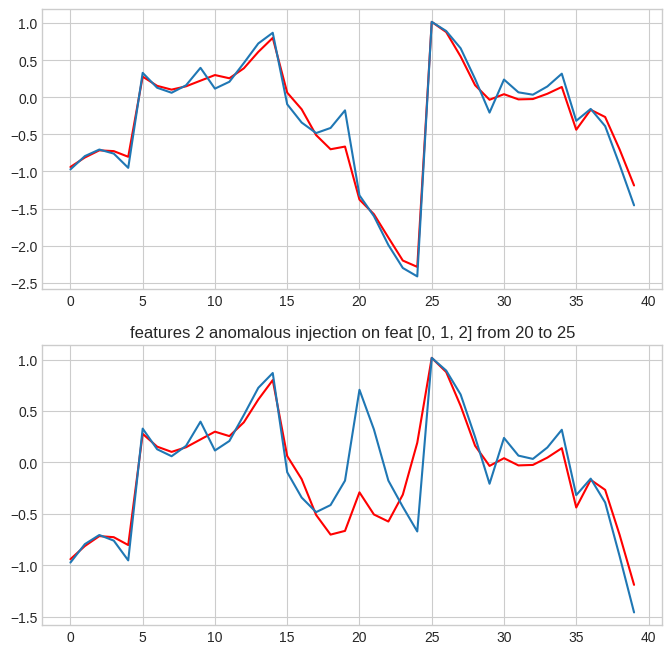

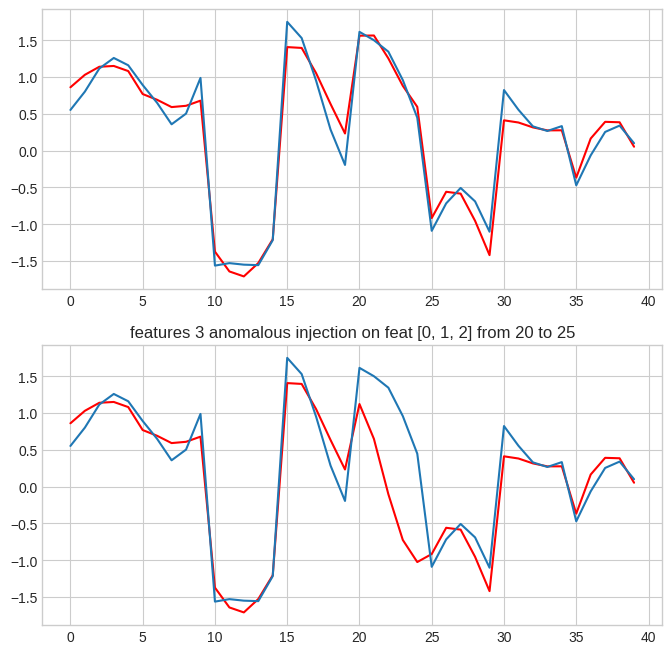

In [28]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig, axs = plt.subplots(2, figsize=(8,8))
    #x = np.linspace(0, sequence_length)
    axs[0].plot(yo.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy(), 'r')
    axs[0].plot(x.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())
    plt.title('no anomalies')
    axs[1].plot(yo_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy(), 'r')
    axs[1].plot(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())

    an_idx = len(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())//2

    plt.title('features {} anomalous injection on feat {} from {} to {}'\
              .format(i ,injected, int(an_idx), int(an_idx)+ batch))